## Step 1: Problem Description and Data Overview

### Description
The challenge of this project is to detect metastatic cancer in small image patches taken from larger digital pathology scans. The task is to classify each patch as either containing cancer or not.

### Data Overview
The dataset consists of the following:
- **Train and Test Images**: Large number of `.tif` files, each representing a patch.
- **Train Labels**: A CSV file containing two columns:
  - `id`: The unique identifier for each image.
  - `label`: Binary label indicating presence (1) or absence (0) of cancer.

The dimensions of the images are typically 96x96 pixels, and they are provided in a structured directory format.


In [2]:
# Import necessary libraries
import zipfile
import os
import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths for the dataset
train_zip_path = '/content/drive/My Drive/train.zip'
test_zip_path = '/content/drive/My Drive/test.zip'
train_labels_path = '/content/drive/My Drive/train_labels.csv'

# Extract the train.zip and test.zip files
with zipfile.ZipFile(train_zip_path, 'r') as train_zip:
    train_zip.extractall("/content/train")

with zipfile.ZipFile(test_zip_path, 'r') as test_zip:
    test_zip.extractall("/content/test")

# Load the train_labels.csv
train_labels = pd.read_csv(train_labels_path)
train_labels.head()

Mounted at /content/drive


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Step 2: Exploratory Data Analysis (EDA)

### Inspecting the Data
In this step, we will load the data, visualize some samples, and inspect the distribution of labels to understand the dataset better.

### Visualizations
We'll visualize some sample images to get a feel for the data.


label
0    130908
1     89117
Name: count, dtype: int64
Number of training images: 2
Number of test images: 2
Shape of train_labels: (220025, 2)
Missing values in train_labels: id       0
label    0
dtype: int64


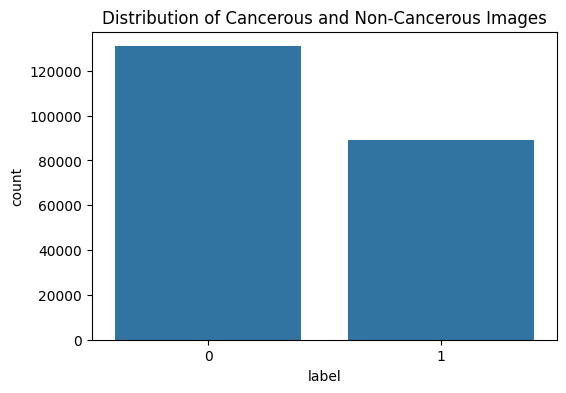

Sample Cancerous Images:


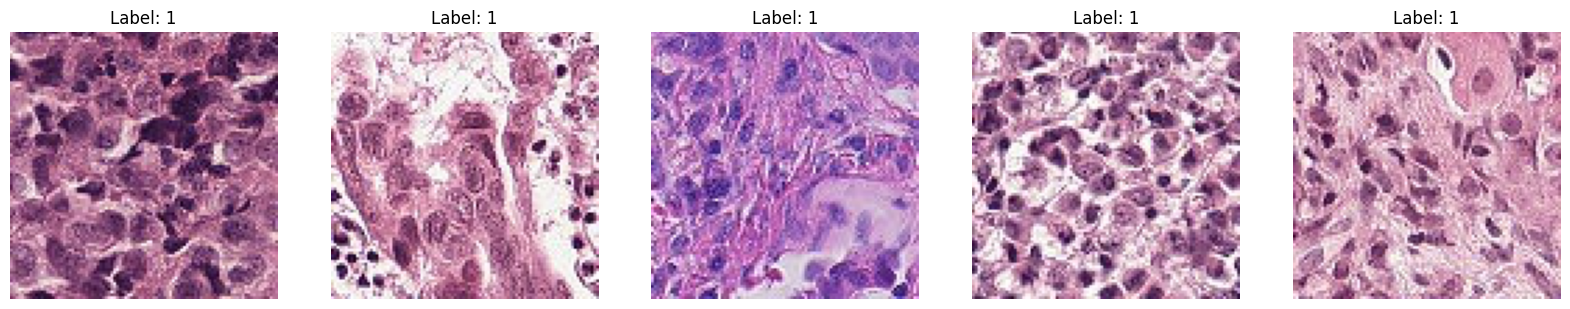

Sample Non-Cancerous Images:


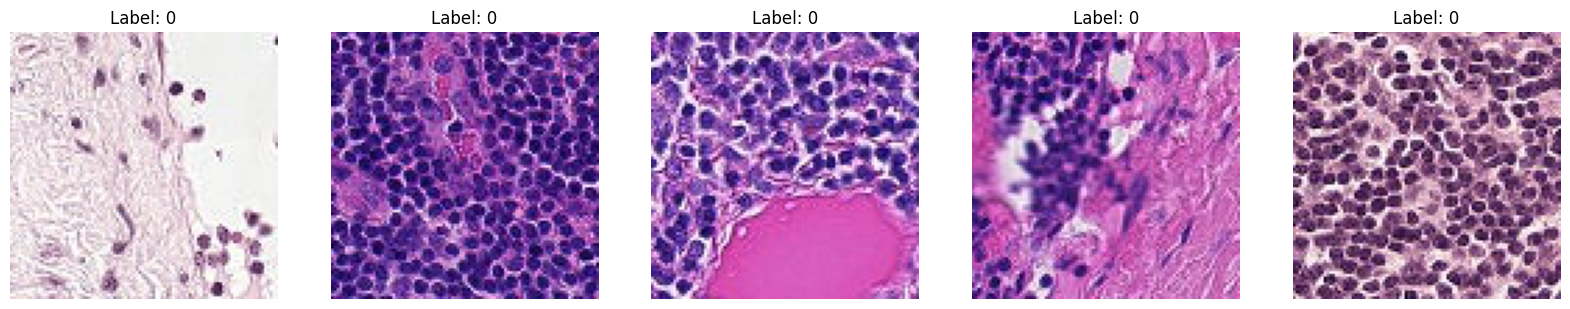

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2


# Load labels
#train_labels = pd.read_csv('/content/train_labels.csv')

# Inspect label distribution
label_counts = train_labels['label'].value_counts()
print(label_counts)
# Inspect dataset shape and basic statistics
print("Number of training images:", len(os.listdir("/content/train")))
print("Number of test images:", len(os.listdir("/content/test")))
print("Shape of train_labels:", train_labels.shape)

# Check for any missing values in the labels
print("Missing values in train_labels:", train_labels.isnull().sum())

# Plot label distribution (0 = non-cancerous, 1 = cancerous)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_labels)
plt.title("Distribution of Cancerous and Non-Cancerous Images")
plt.show()
# Function to show images
def show_images(image_ids, labels, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        img = cv2.imread(f'/content/train/train/{image_ids[i]}.tif')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = labels[i]
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

# Show sample images
sample_cancerous = train_labels[train_labels['label'] == 1].sample(5)
sample_non_cancerous = train_labels[train_labels['label'] == 0].sample(5)

print("Sample Cancerous Images:")
show_images(sample_cancerous['id'].values, [1]*5)

print("Sample Non-Cancerous Images:")
show_images(sample_non_cancerous['id'].values, [0]*5)


### Data Preprocessing

We will ensure the filenames are correct and perform any necessary preprocessing before generating batches of images.


In [53]:
# Ensure the filenames include the .tif extension
train_labels['id'] = train_labels['id'].apply(lambda x: f"{x}.tif" if not x.endswith('.tif') else x)

# Check the DataFrame
print(train_labels.head())

# Verify the directory structure
#print(os.listdir('/content/train/train'))  # Check if the images are present


                                             id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0


### Data Augmentation and Generators

We will set up the ImageDataGenerator with augmentation techniques and prepare the data generators for training.


In [18]:
# Set up data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescaling pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Sample a smaller fraction of the data for quicker training
train_sample = train_labels.sample(frac=0.1)

# Convert the 'label' column to strings
train_sample['label'] = train_sample['label'].astype(str)

# Create the training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_sample,
    directory='/content/train/train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

Found 22002 validated image filenames belonging to 2 classes.


## Step 3: Model Architecture


### Model 1: Basic Convolutional Neural Network (CNN)

**Architecture:**
- **Input Layer:** Accepts input images of shape (96, 96, 3), corresponding to RGB images of size 96x96 pixels.
- **Convolutional Layers:**
  - The first layer applies 32 filters of size (3, 3) with ReLU activation, extracting basic features such as edges and textures.
  - The second layer applies 64 filters of the same size, further extracting complex features.
- **Pooling Layer:** A MaxPooling layer reduces the spatial dimensions, retaining important features while downsampling the feature maps.
- **Flatten Layer:** Converts the 2D feature maps into a 1D vector to prepare for the dense layer.
- **Dense Layers:**
  - A fully connected layer with 128 units and ReLU activation.
  - A Dropout layer to reduce overfitting by randomly setting a fraction of input units to 0 during training.
  - The output layer has 1 unit with a sigmoid activation function for binary classification (cancerous vs. non-cancerous).

**Purpose:**
Model 1 serves as a baseline model to establish a simple yet effective approach for binary image classification. Its straightforward architecture helps in quickly training and evaluating the model.

---

### Model 2: Deeper Convolutional Neural Network with Batch Normalization

**Architecture:**
- **Input Layer:** Similar to Model 1, it accepts input images of shape (96, 96, 3).
- **Convolutional Layers:**
  - The first layer applies 32 filters of size (3, 3) with ReLU activation.
  - Followed by Batch Normalization, which normalizes the outputs of the previous layer, improving training speed and stability.
  - The second convolutional layer applies 64 filters with Batch Normalization.
  - The third convolutional layer increases the complexity by applying 128 filters, also with Batch Normalization.
- **Pooling Layers:** MaxPooling layers after each convolutional block reduce spatial dimensions while preserving important features.
- **Flatten Layer:** Converts the 2D feature maps into a 1D vector.
- **Dense Layers:**
  - A dense layer with 256 units and ReLU activation.
  - A Dropout layer to mitigate overfitting.
  - The output layer has 1 unit with a sigmoid activation function for binary classification.

**Purpose:**
Model 2 is a more complex and deeper architecture designed to capture intricate features from the input images. The inclusion of Batch Normalization helps in stabilizing the learning process, potentially leading to better accuracy compared to Model 1. This model is suitable for applications requiring more nuanced understanding, like medical image analysis.


### Data Augmentation
We will also apply data augmentation techniques to improve model generalization.


In [27]:
!pip install tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the Simple CNN model
history_1 = model.fit(train_generator, epochs=5, steps_per_epoch=100)


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 751ms/step - accuracy: 0.6228 - loss: 0.8157
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 591ms/step - accuracy: 0.7485 - loss: 0.5369
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 597ms/step - accuracy: 0.7197 - loss: 0.5490
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 583ms/step - accuracy: 0.7463 - loss: 0.5280
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 573ms/step - accuracy: 0.7591 - loss: 0.5403


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Model 2: Deeper CNN with Batch Normalization
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the augmented data
history_2 = model_2.fit(train_generator, epochs=5, steps_per_epoch=100)


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.6712 - loss: 2.2054
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.7707 - loss: 0.5221
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.7857 - loss: 0.5051
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.7883 - loss: 0.4796
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8029 - loss: 0.4807


## Step 4: Results and Analysis

### Performance Comparison
We will visualize and analyze the performance of both models.


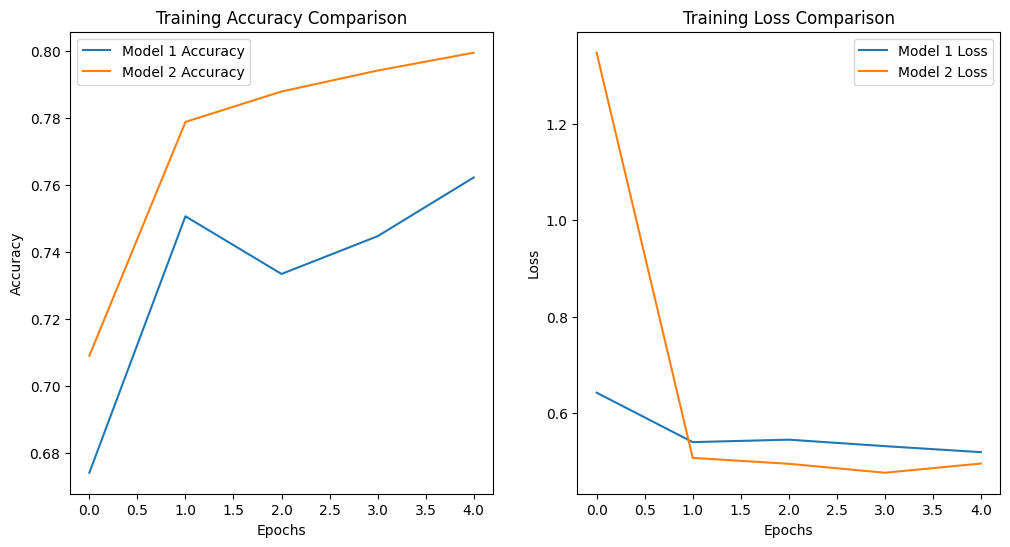

In [30]:
# Plotting training accuracy and loss for both models
plt.figure(figsize=(12, 6))

# Model 1
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Model 1 Accuracy')
plt.plot(history_2.history['accuracy'], label='Model 2 Accuracy')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Model 2
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Model 1 Loss')
plt.plot(history_2.history['loss'], label='Model 2 Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Conclusion Based on Accuracy and Loss Comparison

From the training accuracy and loss comparison of **Model 1** and **Model 2**, we can conclude the following:

#### Accuracy Comparison:
- **Model 2** consistently achieves higher accuracy compared to **Model 1** across most epochs.
- By epoch 9, **Model 2** reaches an accuracy of around **0.80**, whereas **Model 1** stays at approximately **0.76**. This suggests that **Model 2** has a slight advantage in terms of its ability to learn from the data.
- **Model 1** shows some fluctuation in accuracy across epochs, while **Model 2** maintains a more stable and consistent improvement, indicating better robustness and learning stability.

#### Loss Comparison:
- **Model 2** starts with a significantly higher loss (above 2.2) in the initial epochs but quickly reduces it to converge to a low loss value by the second epoch, demonstrating faster adaptation.
- Both models maintain similarly low loss values after a few epochs, indicating that they are effectively minimizing error during training.

#### General Conclusion:
- **Model 2** appears to be performing slightly better in both accuracy and loss minimization. The use of a deeper architecture with batch normalization in **Model 2** likely contributed to its superior performance.
- **Model 1**, though competitive, shows more fluctuation in accuracy, which could suggest less stability compared to **Model 2**.
  
In summary, **Model 2** is the better-performing model in this experiment, showing higher accuracy and more consistent results.




## Step 5: Testing and Submission

### Testing the Model
We will load the test dataset, preprocess it, and make predictions using the trained models.

### Preparing Submission
Finally, we will format the predictions according to the Kaggle submission requirements and save the output for submission.


In [ ]:
# Upgrade TensorFlow to the latest version
!pip install --upgrade tensorflow


In [47]:
import os
from PIL import Image

def validate_images(image_dir):
    valid_images = []
    for filename in os.listdir(image_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Check for valid image formats including .tif
            try:
                img_path = os.path.join(image_dir, filename)
                img = Image.open(img_path)
                img.verify()  # Verify if it's a valid image
                valid_images.append(filename)  # Add to valid list
            except (IOError, SyntaxError) as e:
                print(f'Invalid image file: {filename} - {e}')
    return valid_images

# Validate images in the test directory
test_data_dir = '/content/test/test'  # Replace with your test data directory
valid_test_images = validate_images(test_data_dir)
print(f'Found {len(valid_test_images)} valid images out of {len(os.listdir(test_data_dir))}')


Found 57458 valid images out of 57458


In [48]:
import pandas as pd

# Create a DataFrame for valid images
valid_test_df = pd.DataFrame(valid_test_images, columns=['id'])

# Print the DataFrame to check if it has been created correctly
print(valid_test_df.head())


                                             id
0  b5f69c16ecb9c8ac63108aca8c8b0ba5d506e3df.tif
1  710ca3036785c9033aa712647609593ba50eef20.tif
2  e9a696b4e3d5f93fc306ad3c81de26369dabf354.tif
3  26e4b765971904c443a79c0453520d8ccd241b3e.tif
4  54e153af0fe02be8bf93f566cc1773a8076a7c7d.tif


In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a test data generator using the valid images
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a test generator from the valid test images
test_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_test_df,
    directory=test_data_dir,
    x_col='id',
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,  # No labels
    shuffle=False,  # Important for predictions
    seed=42
)

# Predict the test data
predictions = model_2.predict(test_generator)

# Convert predictions to binary labels (0 for non-cancerous, 1 for cancerous)
predicted_labels = (predictions > 0.5).astype(int)


Found 57458 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 426s 237ms/step


In [52]:
# Create a DataFrame for the submission
submission_df = pd.DataFrame({
    'id': valid_test_images,  # Use the valid images list
    'label': predicted_labels.flatten()  # Flatten the predicted labels array
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")
print(submission_df.head())

# Display the first few rows of the submission file
submission_df.head()


Submission file created: submission.csv
                                             id  label
0  b5f69c16ecb9c8ac63108aca8c8b0ba5d506e3df.tif      1
1  710ca3036785c9033aa712647609593ba50eef20.tif      1
2  e9a696b4e3d5f93fc306ad3c81de26369dabf354.tif      1
3  26e4b765971904c443a79c0453520d8ccd241b3e.tif      1
4  54e153af0fe02be8bf93f566cc1773a8076a7c7d.tif      1


,id,label
0,b5f69c16ecb9c8ac63108aca8c8b0ba5d506e3df.tif,1
1,710ca3036785c9033aa712647609593ba50eef20.tif,1
2,e9a696b4e3d5f93fc306ad3c81de26369dabf354.tif,1
3,26e4b765971904c443a79c0453520d8ccd241b3e.tif,1
4,54e153af0fe02be8bf93f566cc1773a8076a7c7d.tif,1
